<a href="https://colab.research.google.com/github/gunhokim-me/first-ML/blob/master/BasketBall_Player_Positionn_Predict(SVN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 데이터 수집
df = pd.read_csv("https://raw.githubusercontent.com/wikibook/machine-learning/2.0/data/csv/basketball_stat.csv")

In [3]:
# 데이터 다듬기
# 분별력 없는 특징(feature) 을 데이터에서 제거
df.drop(['2P','AST','STL'], axis=1, inplace=True)

In [4]:
#데이터 나누기
#사이킷런의 train_test_split을 사용하면 코드 한줄로 손쉽게 데이터를 나눌수 있음
from sklearn.model_selection import train_test_split

In [5]:
#다듬어진 데이터에서 20%를 테스트 데이터로 분류
train, test = train_test_split(df, test_size=0.2)

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np

def svc_param_selection(X, y, nfolds):
  svm_parameters = [
                    {'kernel': ['rbf'],
                     'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                     'C' : [0.01, 0.1, 1, 10, 100, 1000]
                     }]

  #사이킷런에서 제공하는 GridSearchCV를 사용해 최적의 파라미터를 구현
  clf = GridSearchCV(SVC(), svm_parameters, cv=10)
  clf.fit(X_train, y_train.values.ravel())
  print(clf.best_params_)

  return clf

#3점슛 과 블로킹 횟수를 학습 데이터로 사용
X_train = train[['3P', 'BLK']]

#농구선수 포지션을 예측값으로 선정
y_train = train[['Pos']]

#최적의 파라미터로 학습된 모델을 clf로 저장
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [7]:
#위 결과에 따라 SVM의 최적 비용(C)는 1, 감마(gamma)는 0.1

#결정 경계선 시각화

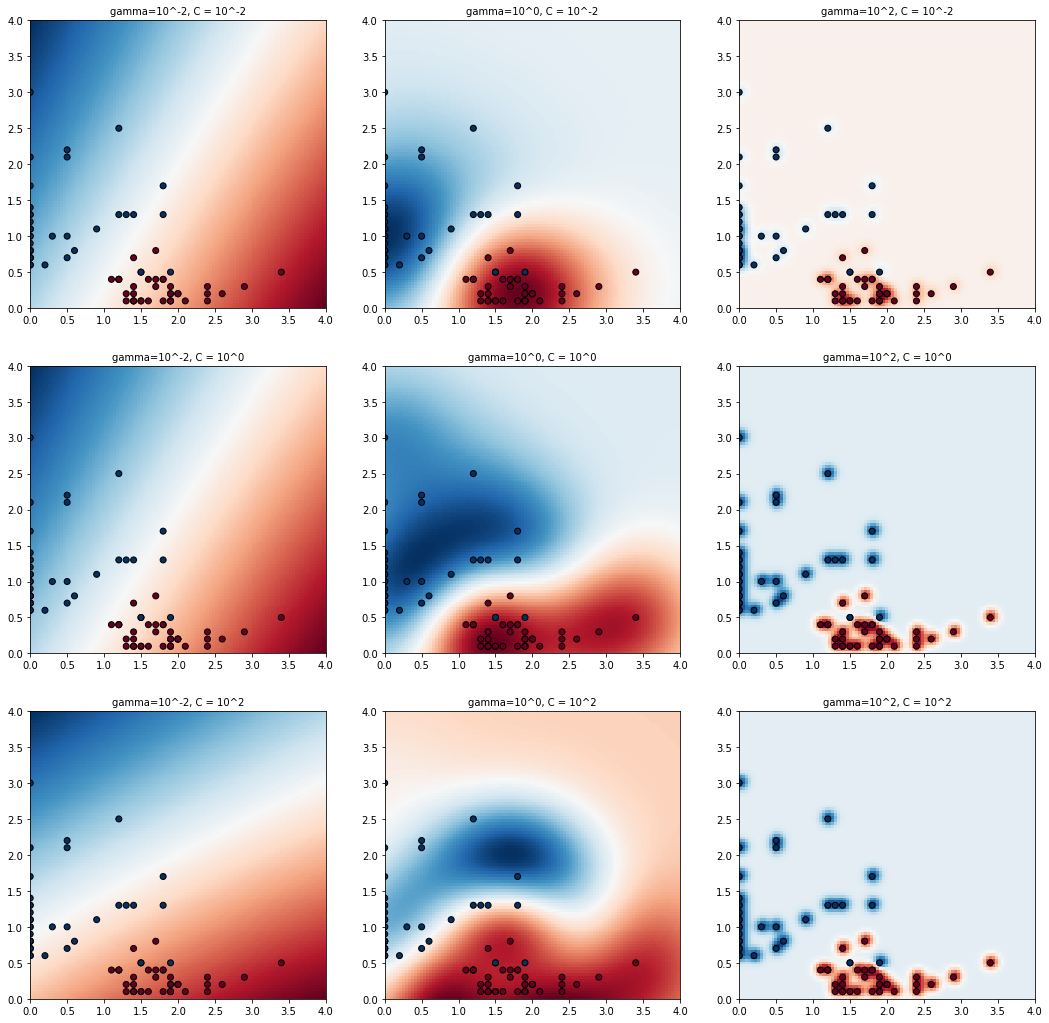

In [8]:
# 시각화 할 비용 후보들을 저장
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C'])
C_canditates.append(clf.best_params_['C'] * 100)

#시각화할 감마 후보들을 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

#3점슛과 블로킹 횟수로 학습
X = train[['3P', 'BLK']]

#농구선수 포지션을 학습 모델의 분류값으로 사용
Y = train['Pos'].tolist()

#시각화를 위해 센터(C) 와 슈팅가드(SG) 를 숫자로 표현
position = []
for gt in Y:
  if gt == 'C':
    position.append(0)
  else:
    position.append(1)

classifiers = []

#파라미터 후보들을 조합해서 학습된 모델들을 저장
for C in C_canditates:
  for gamma in gamma_candidates:
    clf = SVC(C=C, gamma=gamma)
    clf.fit(X.values,Y)
    classifiers.append((C, gamma, clf))

#각 모델을 시각화
plt.figure(figsize=(18,18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

for(k, (C, gamma, clf)) in enumerate(classifiers):
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.subplot(len(C_canditates), len(gamma_candidates),k + 1)
  plt.title('gamma=10^%d, C = 10^%d'% (np.log10(gamma), np.log10(C)), size='medium')

  plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
  plt.scatter(X['3P'],X['BLK'],c=position, cmap=plt.cm.RdBu_r, edgecolors='k')

#모델 테스트

In [12]:
X_test = test[['3P', 'BLK']]
y_test = test[['Pos']]

#최적의 파라미터로 학습된 모델로 테스트를 진행
y_true, y_pred = y_test, clf.predict(X_test.values)

print(classification_report(y_true, y_pred))
print()
print('accuracy : ' + str(accuracy_score(y_true, y_pred)))

              precision    recall  f1-score   support

           C       0.73      0.89      0.80         9
          SG       0.89      0.73      0.80        11

    accuracy                           0.80        20
   macro avg       0.81      0.81      0.80        20
weighted avg       0.82      0.80      0.80        20


accuracy : 0.8


In [10]:
comparison = pd.DataFrame({'prediction' : y_pred, 
                           'ground_truth' : y_true.values.ravel()})
comparison

,prediction,ground_truth
0,SG,SG
1,C,C
2,C,C
3,C,SG
4,C,SG
5,SG,SG
6,C,C
7,SG,SG
8,SG,SG
9,C,C
